# Initial Python Setup

In [1]:
import os
import pandas as pd
import requests as req
import numpy as np
import statsmodels.api as stapi
import statsmodels.formula.api as smf

from zipfile import ZipFile
from io import BytesIO
from IPython.display import display
from matplotlib import rc as pltrc
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import RegressionResults, RegressionResultsWrapper

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Initial Variables
Here, we just set up initial variables and configuration to clean up code and results

In [2]:
url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
file_name = 'survey_results_public.csv'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

font = {
    'family': 'normal',
    'weight': 'bold',
    'size': 10
}
pltrc('font', size=8)

# Importing the Dataset
Here we download and import the dataset in memory to eliminate the need of local storage.

In [3]:
response = req.get(url)
zip_file = ZipFile(BytesIO(response.content))
df = pd.read_csv(BytesIO(zip_file.read(file_name)))
display(df)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.0,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trello,Slack;Zoom

# Cleaning the Data

In order to use the dataset, we will first clean it up and interpret some of the variables into dummy variables.

## Dummy Variables

Many of the variables in the data are multi-selected lists, where the user can choose none, any, or all of the options. These are stored as a list seperated by a `;` deliminer.

We can use the dataframe method

```python
df.str.get_dummies(';')
```

to split these up into dummy variables. We will keep the individual data frames so we can access all of the columns with

```python
list(dummy_df.columns)
```

Additionally, we will rename some columns in this step in order to make it usable in regressions

In [4]:
dummy_languages = df["LanguageHaveWorkedWith"].str.get_dummies(';').rename(columns={
  "C#": "CSharp",
  "F#": "FSharp",
  "Bash/Shell": "Bash",
  "HTML/CSS": "HTML",
  "Objective-C": "ObjectiveC"
})
dummy_devtype = df["DevType"].str.get_dummies(";").rename(columns={
  "Academic researcher": "AcademicResearcher",
  "Cloud infrastructure engineer": "CloudInfrastructureEngineer",
  "Data or business analyst": "DataBusinessAnalyst",
  "Data scientist or machine learning specialist": "DataScientistMachineLearning",
  "Database administrator": "DatabaseAdministrator",
  "DevOps specialist": "DevOpsSpecialist",
  "Developer, QA or test": "DevQATest",
  "Developer, back-end": "DevBackend",
  "Developer, desktop or enterprise applications": "DevDesktopApps",
  "Developer, embedded applications or devices": "DevEmbedded",
  "Developer, front-end": "DevFrontend",
  "Developer, full-stack": "DevFullstack",
  "Developer, game or graphics": "DevGame",
  "Developer, mobile": "DevMobile",
  "Engineer, data": "DataEngineer",
  "Engineer, site reliability": "SiteReliabilityEngineer",
  "Engineering manager": "EngineerManager",
  "Marketing or sales professional": "MarketingSales",
  "Other (please specify):": "Other",
  "Product manager": "ProductManager",
  "Project manager":"ProjectManager",
  "Security professional": "Security",
  "Senior Executive (C-Suite, VP, etc.)": "SeniorExec",
  "System administrator": "SystemAdmin"
}).add_prefix("DevType")
dummy_employment = df["Employment"].str.get_dummies(";").rename(columns={
  "Employed, full-time": "FullTime",
  "Employed, part-time": "PartTime",
  "I prefer not to say": "Unknown",
  "Independent contractor, freelancer, or self-employed": "SelfEmployed",
  "Not employed, and not looking for work": "UnemployedNotLooking",
  "Not employed, but looking for work": "UnemployedLooking",
  "Student, full-time": "StudentFullTime",
  "Student, part-time": "StudentPartTime"
}).add_prefix("Employed")

df = pd.concat([df,dummy_languages,dummy_devtype,dummy_employment], axis=1)
display(df)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,APL,Assembly,Bash,C,CSharp,C++,COBOL,Clojure,Crystal,Dart,Delphi,Elixir,Erlang,FSharp,Fortran,Go,Groovy,HTML,Haskell,Java,JavaScript,Julia,Kotlin,LISP,Lua,MATLAB,OCaml,ObjectiveC,PHP,Perl,PowerShell,Python,R,Ruby,Rust,SAS,SQL,Scala,Solidity,Swift,TypeScript,VBA,DevTypeAcademicResearcher,DevTypeBlockchain,DevTypeCloudInfrastructureEngineer,DevTypeDataBusinessAnalyst,DevTypeDataScientistMachineLearning,DevTypeDatabaseAdministrator,DevTypeDesigner,DevTypeDevOpsSpecialist,DevTypeDevQATest,DevTypeDevBackend,DevTypeDevDesktopApps,DevTypeDevEmbedded,DevTypeDevFrontend,DevTypeDevFullstack,DevTypeDevGame,DevTypeDevMobile,DevTypeEducator,DevTypeDataEngineer,DevTypeSiteReliabilityEngineer,DevTypeEngineerManager,DevTypeMarketingSales,DevTypeOther,DevTypeProductManager,DevTypeProjectManager,DevTypeScientist,DevTypeSecurity,DevTypeSeniorExec,DevTypeStudent,DevTypeSystemAdmin,EmployedFullTime,EmployedPartTime,EmployedUnknown,EmployedSelfEmployed,EmployedUnemployedNotLooking,EmployedUnemployedLooking,EmployedRetired,EmployedStudentFullTime,EmployedStudentPartTime
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaSc

## Converting "Other" entries to their numbers
Some of the columns that we use are numbers, but they also include values such as "less than 1 year", etc. For that reason, we'll be replacing those values with values we can use to regress easier

In [5]:
df["YearsCodeNumeric"] = pd.to_numeric(df["YearsCode"].replace({
  "Less than 1 year": 0,
  "More than 50 years": 50
}))
df["YearsCodeProNumeric"] = pd.to_numeric(df["YearsCodePro"].replace({
  "Less than 1 year": 0,
  "More than 50 years": 50
}))

## Filtering Data

Because the data is so vast across multiple countries and currencies, we will need to filter the data down to only rows that has everything we want in the format that we want, we'll store this filtered data separately as `dfreg`

In [6]:
dfreg = df[
  (df["Country"] == "United States of America") &
  (df["ConvertedCompYearly"].notna())
]
display(dfreg)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,APL,Assembly,Bash,C,CSharp,C++,COBOL,Clojure,Crystal,Dart,Delphi,Elixir,Erlang,FSharp,Fortran,Go,Groovy,HTML,Haskell,Java,JavaScript,Julia,Kotlin,LISP,Lua,MATLAB,OCaml,ObjectiveC,PHP,Perl,PowerShell,Python,R,Ruby,Rust,SAS,SQL,Scala,Solidity,Swift,TypeScript,VBA,DevTypeAcademicResearcher,DevTypeBlockchain,DevTypeCloudInfrastructureEngineer,DevTypeDataBusinessAnalyst,DevTypeDataScientistMachineLearning,DevTypeDatabaseAdministrator,DevTypeDesigner,DevTypeDevOpsSpecialist,DevTypeDevQATest,DevTypeDevBackend,DevTypeDevDesktopApps,DevTypeDevEmbedded,DevTypeDevFrontend,DevTypeDevFullstack,DevTypeDevGame,DevTypeDevMobile,DevTypeEducator,DevTypeDataEngineer,DevTypeSiteReliabilityEngineer,DevTypeEngineerManager,DevTypeMarketingSales,DevTypeOther,DevTypeProductManager,DevTypeProjectManager,DevTypeScientist,DevTypeSecurity,DevTypeSeniorExec,DevTypeStudent,DevTypeSystemAdmin,EmployedFullTime,EmployedPartTime,EmployedUnknown,EmployedSelfEmployed,EmployedUnemployedNotLooking,EmployedUnemployedLooking,EmployedRetired,EmployedStudentFullTime,EmployedStudentPartTime,YearsCodeNumeric,YearsCodeProNumeric
11,12,"I am not primarily a developer, but I write co...","Employed, full-time;Independent contractor, fr...",Fully remote,Hobby;Contribute to open-source projects;Freel...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,NaN,12,10,Engineering manager,20 to 99 employees,I have some influence,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,194400.0,Yearly,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,C++;Go;HTML/CSS;JavaScript;Lua;Rust;TypeScript,Couchbase;CouchDB;Microsoft SQL Server;MongoDB...,Elasticsearch;MongoDB;Redis;SQLite,AWS;Microsoft Azure,AWS;DigitalOcean;Firebase;Linode,ASP.NET;ASP.NET Core ;Express;Node.js;Vue.js,ASP.NET Core ;Node.js;Nuxt.js;React.js;Vue.js,.NET;Keras;NumPy;Pandas;Scikit-learn;TensorFlo...,Keras;NumPy;Pandas;Scikit-learn;TensorFlow;Tor...,Docker;Homebrew;Kubernetes,Docker;Homebrew;Kubernetes;Pulumi;Terraform,IPython/Jupyter;Neovim;Visual Studio;Visual St...,IPython/Jupyter;Neovim;Visual Studio Code,Linux-based;macOS;Windows,Linux-based;macOS,Git,Code editor;Dedicated version control GUI appl...,NaN,NaN,Confluence;Jira Work Management;Notion;Trello,Notion;Trello,Cisco Webex Teams;Google Chat;Microsoft Teams;...,Slack,Unfavorable,Stack Overflow;Stack Exchange,Daily or almost daily,Yes,A few times per month or weekly,"Yes, somewhat",35-44 years old,Man,No,Straight / Heterosexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",Yes,People manager,14.0,Strongly agree,Agree,Disagree,Agree,Agree,Agree,Agree,10+ times a week,10+ times a week,3-5 times a week,30-

# Helper Functions


## Visualizing Results
This function will help with visualizing the results that we see in each outcome, specifically the relationship between language and salary

In [7]:
def visualize_regression(regression: RegressionResultsWrapper, left_log = True):
  table = regression.summary2().tables[1]
  table = table[table.index.isin(list(dummy_languages.columns))]
  table = table.sort_values(by=["Coef."])
  plt.figure(figsize=(25,5))
  plt.xticks(rotation=90)
  plt.bar(table.index,table["Coef."] * 100,width=25/len(list(dummy_languages.columns)))
  plt.ylabel("Percent Change in Salary (%)" if left_log else "Change in Salary")
  plt.xlabel("Language (From lowest to highest change in salary)")

# Running Regressions
Below will be regressions walking through the process to get to the final regression used for analysis

First, we'll make a string variable for each of the dummy sets that just prints each of the columns in that segment, joined by addition

In [8]:
var_languages = " + ".join(list(dummy_languages.columns))
var_devtype = " + ".join(list(dummy_devtype.columns))
var_employment = " + ".join(list(dummy_employment.columns))

## The Basic Regression
The most basic regression that we can do is just modeling how the languages affects yearly compensation

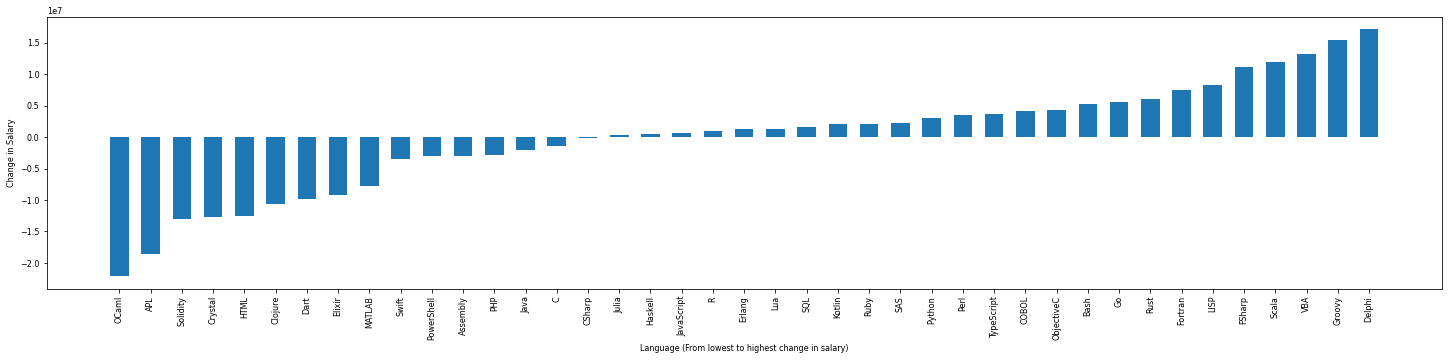

In [9]:
ols_basic = ols(f"ConvertedCompYearly ~ {var_languages}", data = dfreg).fit()
visualize_regression(ols_basic, left_log = False)

## Logging Converted Comp Yearly
By logging converted comp yearly, our interpretation of the coefficients is that knowing that particular language will result in a X% increase in the compensation

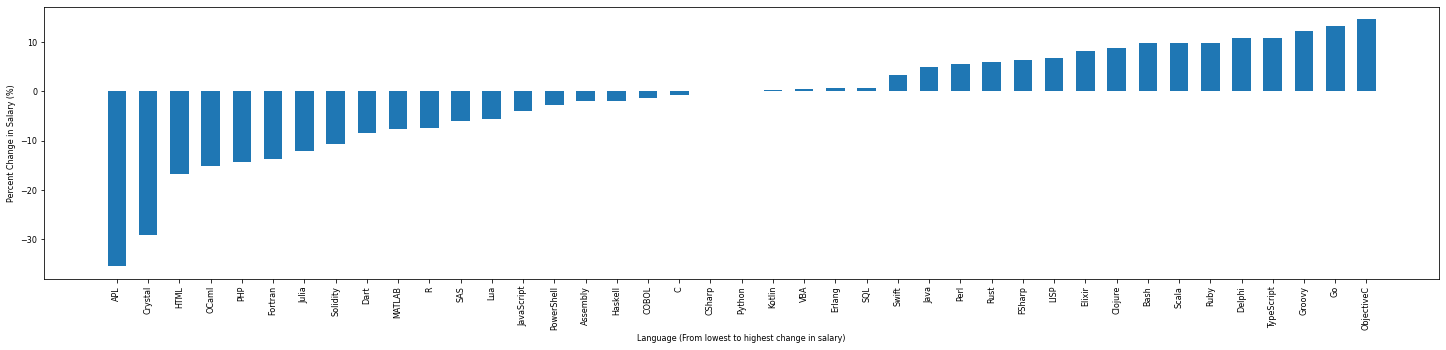

In [10]:
ols_logsalary = ols(f"np.log(ConvertedCompYearly) ~ {var_languages}", data = dfreg).fit()
visualize_regression(ols_logsalary)

# Controlling for Developer Type

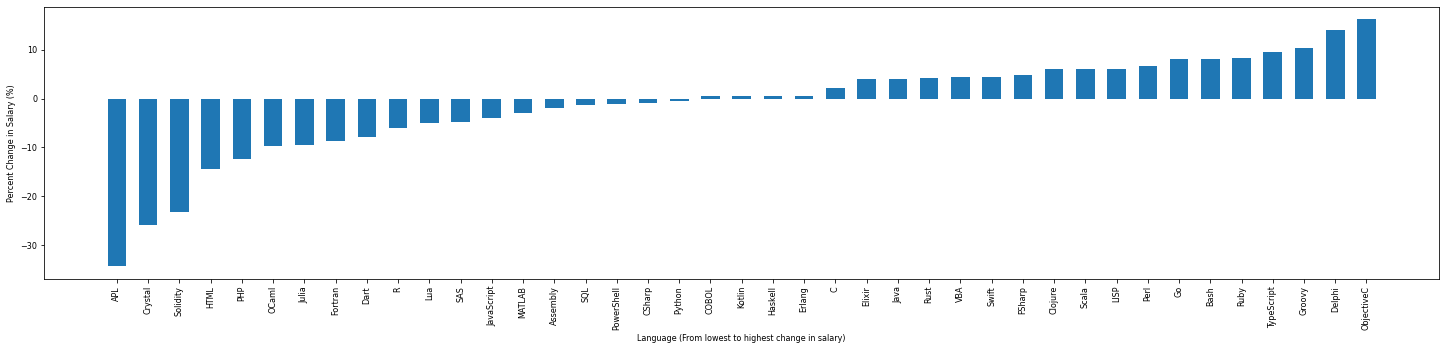

In [11]:
ols_devtype = ols(f"np.log(ConvertedCompYearly) ~ {var_languages} + {var_devtype}", data = dfreg).fit()
visualize_regression(ols_devtype)

## Controlling for just employment status

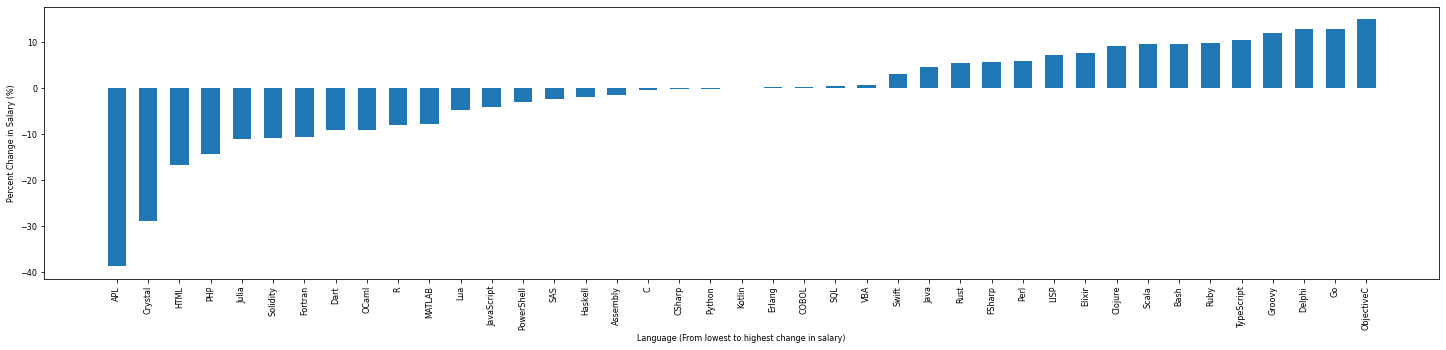

In [12]:
ols_employed = ols(f"np.log(ConvertedCompYearly) ~ {var_languages} + {var_employment}", data = dfreg).fit()
visualize_regression(ols_employed)

## CONTROLLING FOR EVERYTHING

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     np.log(ConvertedCompYearly)   R-squared:                       0.053
Model:                                     OLS   Adj. R-squared:                  0.047
Method:                          Least Squares   F-statistic:                     8.560
Date:                         Fri, 16 Dec 2022   Prob (F-statistic):           2.31e-66
Time:                                 12:50:10   Log-Likelihood:                -12024.
No. Observations:                         8675   AIC:                         2.416e+04
Df Residuals:                             8618   BIC:                         2.456e+04
Df Model:                                   56                                         
Covariance Type:                     nonrobust                                         
=================================================================================================================================================================
                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        11.4233      0.092    124.752      0.000      11.244      11.603
EdLevel[T.Bachelor’s degree (B.A., B.S., B.Eng., etc.)]                                           0.1210      0.052      2.322      0.020       0.019       0.223
EdLevel[T.Master’s degree (M.A., M.S., M.Eng., MBA, etc.)]                                        0.2061      0.056      3.671      0.000       0.096       0.316
EdLevel[T.Other doctoral degree (Ph.D., Ed.D., etc.)]                                             0.1838      0.076      2.419      0.016       0.035       0.333
EdLevel[T.Primary/elementary school]                                                              0.2836      0.172      1.645      0.100      -0.054       0.622
EdLevel[T.Professional degree (JD, MD, etc.)]                                                     0.1348      0.145      0.932      0.351      -0.149       0.418
EdLevel[T.Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)]    -0.0444      0.086     -0.516      0.606      -0.213       0.124
EdLevel[T.Some college/university study without earning a degree]                                 0.0758      0.059      1.285      0.199      -0.040       0.191
EdLevel[T.Something else]                                                                         0.2073      0.202      1.028      0.304      -0.188       0.603
APL                                                                                              -0.2727      0.190     -1.433      0.152      -0.646       0.100
Assembly                                                                                         -0.0049      0.063     -0.078      0.938      -0.129       0.119
Bash                                                                                              0.0773      0.023      3.312      0.001       0.032       0.123
C                                                                                                -0.0327      0.036     -0.915      0.360      -0.103       0.037
CSharp                                                                                           -0.0200      0.026     -0.767      0.443      -0.071       0.031
COBOL                                                                                             0.0473      0.131      0.360      0.719      -0.210       0.305
Clojure                                                             

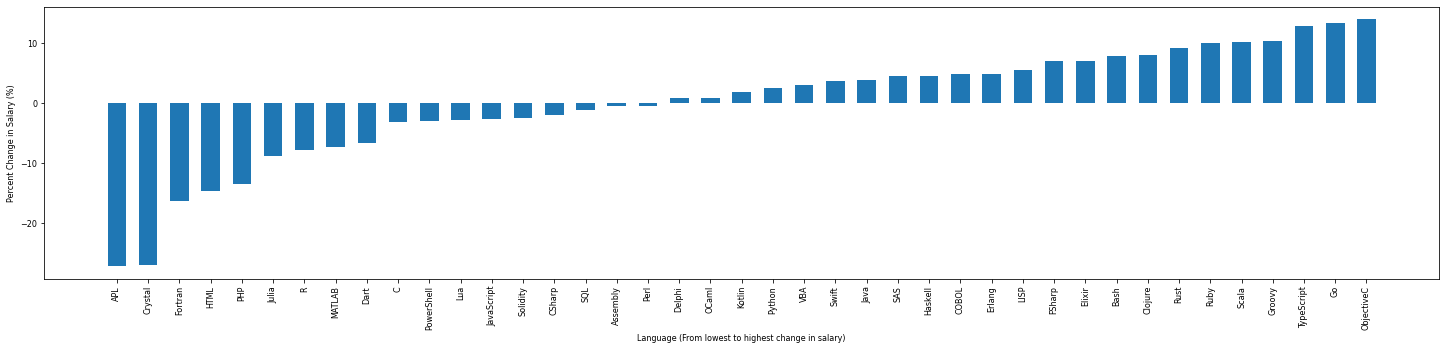

In [13]:
ols_all = ols(f"np.log(ConvertedCompYearly) ~ {var_languages} + {var_employment} + {var_employment} + YearsCodeNumeric +	YearsCodeProNumeric + EdLevel", data = dfreg).fit()
display(ols_all.summary())
visualize_regression(ols_all)